In [2]:
# python imports
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

from sklearn import neighbors, datasets, feature_selection
from sklearn.cross_validation import train_test_split, cross_val_score

import collections
import operator
import math

In [3]:
# Load in the data
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

iris_df['Target'] = iris.target

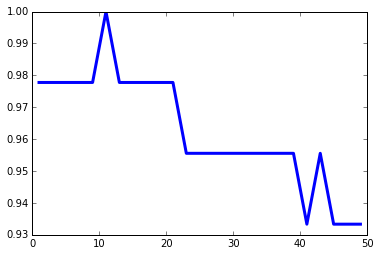

In [4]:
# split data and target classifications into train and test sets and run KNN classification
def knn(data, target, n_neighbors):

    # split the data into train and test datasets
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=12)

    # Loop through each K value, run KNN classification, and append the scores to the output
    scores = []
    for n in n_neighbors:
        clf = neighbors.KNeighborsClassifier(n)
        clf.fit(x_train, y_train)
        scores.append(clf.score(x_test, y_test))
        
    return scores

# use odd for K from 1 to 51
n_neighbors = range(1, 51, 2)

# get the scores
scores = knn(iris.data, iris.target, n_neighbors)

# plot result as K vs score
plt.plot(n_neighbors, scores, linewidth=3.0)

In [5]:
# run 5-fold cross-validation on the input and targets and return the scores
def xvalidate(data, target, n_neighbor, n_folds):
    clf = neighbors.KNeighborsClassifier(n_neighbor, weights='uniform')
    clf.fit(data, target)
    scores = cross_val_score(clf, data, target, cv=n_folds)
    return scores

# simple util method for getting the mean value of a list
def mean(values):
    tot = 0
    for v in values:
        tot += v
    return tot / len(values)

# run cross-validation using a series of K values
for x in range(1, 51, 2):
    xvalidate_scores = xvalidate(iris.data, iris.target, x, 5)
    print xvalidate_scores
    print mean(xvalidate_scores)

[ 0.96666667  0.96666667  0.93333333  0.93333333  1.        ]
0.96
[ 0.96666667  0.96666667  0.93333333  0.96666667  1.        ]
0.966666666667
[ 0.96666667  1.          0.93333333  0.96666667  1.        ]
0.973333333333
[ 0.96666667  1.          0.96666667  0.96666667  1.        ]
0.98
[ 0.96666667  1.          0.96666667  0.93333333  1.        ]
0.973333333333
[ 0.93333333  1.          1.          0.96666667  1.        ]
0.98
[ 0.93333333  1.          0.96666667  0.96666667  1.        ]
0.973333333333
[ 0.93333333  1.          0.93333333  0.96666667  1.        ]
0.966666666667
[ 0.93333333  1.          0.93333333  0.96666667  1.        ]
0.966666666667
[ 0.93333333  1.          0.93333333  0.96666667  1.        ]
0.966666666667
[ 0.93333333  1.          0.93333333  0.96666667  1.        ]
0.966666666667
[ 0.93333333  1.          0.93333333  0.93333333  1.        ]
0.96
[ 0.93333333  0.96666667  0.93333333  0.96666667  1.        ]
0.96
[ 0.9         0.96666667  0.93333333  0.93333333 

In [6]:
print len(iris.data)

# find the optimal K which is the highest value of K with the best score
# determined by 5-fold cross-validation on a list of odd-numbered K from 1 to 51
def find_optimal_k(data):
    max_neighbors = int(len(data) / 2)
    neighbor_scores = {}
    for x in range(1, max_neighbors, 1):
        xvalidate_scores = xvalidate(iris.data, iris.target, x)        
        avg = mean(xvalidate_scores)
        neighbor_scores[x] = avg
    max_value = max(neighbor_scores.values())
    indices = [i for i, x in enumerate(neighbor_scores.values()) if x == max_value]
    max_index = indices[-1] + 1 # add 1 from 0-based indexing
    return max_index, neighbor_scores

k, neighbor_scores = find_optimal_k(iris.data)
print "neighbor scores", neighbor_scores
print "optimal K =", k

150


TypeError: xvalidate() takes exactly 4 arguments (3 given)

In [ ]:
plt.plot(neighbor_scores.keys(), neighbor_scores.values())

In [ ]:
import random
def my_xvalidate(data, target, folds, n_neighbors):
    
    # make a list of the indices in the dataset
    data_indices = range(0, len(data), 1)
    
    # shuffle the indices
    random.shuffle(data_indices)
    
    # get the number of items in each fold
    n_items = int((len(data) / folds))
    
    # start index for fold
    begin_index = 0
    
    # end index for fold
    end_index = n_items - 1
    
    scores = []
    
    # iterate over the folds
    for n_fold in range(folds):
        
        # get the data for this fold
        fold_data = data[begin_index:end_index, :]
        
        # get the labels for this fold
        fold_labels = target[begin_index:end_index]
        
        # score this fold
        fold_score = knn(fold_data, fold_labels, n_neighbors)
        
        # append the score for this fold
        scores.append(fold_score[0])
        
        # increment begin and end indices for next fold
        begin_index += n_items
        end_index += n_items    
    return scores
    
# run cross-validation on all iris data using 5-fold cross-validation with K = 11
scores = my_xvalidate(iris.data, iris.target, 5, [11])
print scores
print mean(scores)

In [ ]:
n_folds = [2, 3, 5, 6, 10, 15]
xvalidate_scores = []
for f in n_folds:
    scores = xvalidate(iris.data, iris.target, 12, f)
    xvalidate_scores.append(mean(scores))
    
plt.plot(n_neighbors, xvalidate_scores)

In [9]:
import math

# compute distance between two N-dimensional points
def dist(data1, data2):
    tot = 0
    
    # loop over each dimension in the data
    for i in range(len(data1)):
        # append distance value for a single dimension
        d = data1[i] - data2[i]
        tot += math.pow(d, 2)
        
    # return square root of sums
    return math.sqrt(tot)

# get the label of a point by looking at the classification of its K closest neighbors
def get_label(data, labels, point_index, k):
        
    # get the point at the index
    point = data[point_index]
        
    # get the distances between this point and every other one
    distances = {}
    for i in range(len(data)):
        if (i != point_index):
            distances[i] = dist(data[i], point)
        
    # sort the distances
    sorted_distances = sorted(distances.items(), key=operator.itemgetter(1))
         
    # get the data indices of the closest K points, ignoring distance 0 which is this point! 
    indices = []
    for j in range(k+1):
        if (sorted_distances[j][1] != 0.):
            indices.append(sorted_distances[j][0])
            
    # get the labels of these points
    neighbor_labels = []
    for i in indices:
        neighbor_labels.append(labels[i])
                
    # count the label values
    label_counts = collections.Counter(neighbor_labels)
    sorted_counts = sorted(label_counts.items(), key=operator.itemgetter(1))
        
    # return the label with the most counts
    return sorted_counts[0][0]
        
def my_knn(values, target, k):
    labels = []
    # loop over the values
    for i in range(len(values)):
        
        # get the features which will be classified
        value = values[i]
        
        # get the label for a single value 
        label = get_label(values, target, i, k)
        
        # append the label for this point
        labels.append(label)

    # return all label values for the inputs
    return labels

# compute score by comparing test and train data
def compute_score(test, train):
    nright = 0
    for i in range(len(test)):
        if (test[i] == train[i]):
            nright += 1
    return nright / len(test)

# get the labels from running my KNN method (example of just running on all data and labels
# without using stratification)
labels = my_knn(iris.data, iris.target, 5)

#print "labels", labels

score = compute_score(labels, iris.target)
print "score", score

score 0.88
